<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec8-Recommender_Systems/1-Recommender_20M_unmodified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-04-24 05:28:48--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M   104MB/s    in 1.8s    

2021-04-24 05:28:50 (104 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls -la

total 194072
drwxr-xr-x 1 root root      4096 Apr 24 05:34 .
drwxr-xr-x 1 root root      4096 Apr 24 05:24 ..
drwxr-xr-x 4 root root      4096 Apr 21 13:38 .config
drwxr-xr-x 2 root root      4096 Oct 17  2016 ml-20m
-rw-r--r-- 1 root root 198702078 Dec  3  2019 ml-20m.zip
drwxr-xr-x 1 root root      4096 Apr 21 13:39 sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [12]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {}
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis = 1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes                # new_user_id = userId - 1

In [14]:
df.tail()

,userId,movieId,rating,timestamp,new_user_id
20000258,138493,68954,4.5,1258126920,138492
20000259,138493,69526,4.5,1259865108,138492
20000260,138493,69644,3.0,1260209457,138492
20000261,138493,70286,5.0,1258126944,138492
20000262,138493,71619,2.5,1255811136,138492


In [15]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes    # coded new_movie_id by order start from zero

In [18]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [20]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5     # Scaling of rating

In [26]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimemsion
D = 10

In [30]:
print('total # user_ids:', len(user_ids), ', unique # user_ids: ', len(set(user_ids)))

total # user_ids: 20000263 , unique # user_ids:  138493


In [31]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2*self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

  def forward(self, u, m):
    u = self.u_emb(u)  # output is (num_samples, D)
    m = self.m_emb(m)  # output is (num_samples, D)

    # merge
    out = torch.cat((u,m),1)   # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out    

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [33]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [35]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [36]:
# convert to tensors
user_ids_t = torch.from_numpy(user_ids).long()
movie_ids_t = torch.from_numpy(movie_ids).long()
ratings_t = torch.from_numpy(ratings)

In [37]:
# Make datasets
Ntrain = int(0.8 * len(ratings))
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain]
)

test_dataset = torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:]
)

In [38]:
# Data loaders
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [40]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for users, movies, targets in train_loader:
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      
      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    # Get train loss and test loss
    train_loss = np.mean(train_loss)   # a little misleading

    test_loss = []
    for users, movies, targets in test_loader:
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      targets = targets.view(-1,1).float()
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0      
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [44]:
%prun train_losses, test_losses = batch_gd(\
    model, criterion, optimizer, train_loader, test_loader, 25)

Epoch 1/25, Train Loss: 0.7213, Test Loss: 0.7236, Duration: 0:04:35.394728
Epoch 2/25, Train Loss: 0.7061, Test Loss: 0.7112, Duration: 0:04:32.788617
Epoch 3/25, Train Loss: 0.6947, Test Loss: 0.7055, Duration: 0:04:32.556190
Epoch 4/25, Train Loss: 0.6870, Test Loss: 0.7011, Duration: 0:04:34.225932
Epoch 5/25, Train Loss: 0.6816, Test Loss: 0.6966, Duration: 0:04:33.842711
Epoch 6/25, Train Loss: 0.6774, Test Loss: 0.6960, Duration: 0:04:32.526659
Epoch 7/25, Train Loss: 0.6738, Test Loss: 0.6938, Duration: 0:04:33.819716
Epoch 8/25, Train Loss: 0.6705, Test Loss: 0.6908, Duration: 0:04:33.970949
Epoch 9/25, Train Loss: 0.6675, Test Loss: 0.6898, Duration: 0:04:34.422480
Epoch 10/25, Train Loss: 0.6646, Test Loss: 0.6893, Duration: 0:04:35.819341
Epoch 11/25, Train Loss: 0.6619, Test Loss: 0.6876, Duration: 0:04:34.824412
Epoch 12/25, Train Loss: 0.6594, Test Loss: 0.6861, Duration: 0:04:36.846656
Epoch 13/25, Train Loss: 0.6569, Test Loss: 0.6876, Duration: 0:04:37.388271
Epoch 14

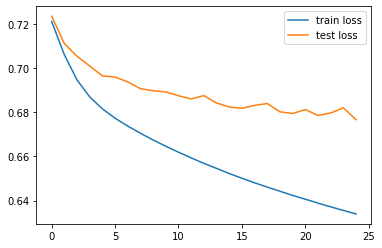

In [45]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()